### **DOMAIN:** 
Semiconductor manufacturing process

### **CONTEXT:**
A complex modern semiconductor manufacturing process is normally under constant surveillance via the monitoring of 
signals/variables collected from sensors and or process measurement points. However, not all of these signals are equally valuable in a 
specific monitoring system. The measured signals contain a combination of useful information, irrelevant information as well as noise. 
Engineers typically have a much larger number of signals than are actually required. If we consider each type of signal as a feature, then 
feature selection may be applied to identify the most relevant signals. The Process Engineers may then use these signals to determine key 
factors contributing to yield excursions downstream in the process. This will enable an increase in process throughput, decreased time to 
learning and reduce the per unit production costs. These signals can be used as features to predict the yield type. And by analysing and 
trying out different combinations of features, essential signals that are impacting the yield type can be identified.
###  **DATA DESCRIPTION:**
signal-data.csv : (1567, 592)
The data consists of 1567 datapoints each with 591 features. 
The dataset presented in this case represents a selection of such features where each example represents a single production entity with 
associated measured features and the labels represent a simple pass/fail yield for in house line testing. Target column “ –1” corresponds to 
a pass and “1” corresponds to a fail and the data time stamp is for that specific test point

### **PROJECT OBJECTIVE:**
We will build a classifier to predict the Pass/Fail yield of a particular process entity and analyse whether all the 
features are required to build the model or not.

In [256]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from scipy.stats import uniform, randint
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import metrics
from sklearn.svm import SVC
from imblearn.over_sampling import RandomOverSampler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score 
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score, LeaveOneOut, KFold, StratifiedKFold
import pickle

### 1. Import and understand the data.

#### A. Import ‘signal-data.csv’ as DataFrame.

In [257]:
df=pd.read_csv("signal-data.csv")

In [258]:
df.head()

,Time,0,1,2,3,4,5,6,7,8,...,581,582,583,584,585,586,587,588,589,Pass/Fail
0,2008-07-19 11:55:00,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,...,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,-1
1,2008-07-19 12:32:00,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,...,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,-1
2,2008-07-19 13:17:00,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,...,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1
3,2008-07-19 14:43:00,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,...,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,-1
4,2008-07-19 15:22:00,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,...,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,-1


#### B. Print 5 point summary and share at least 2 observations.

In [259]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,581,582,583,584,585,586,587,588,589,Pass/Fail
count,1561.000000,1560.000000,1553.000000,1553.000000,1553.000000,1553.0,1553.000000,1558.000000,1565.000000,1565.000000,...,618.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1567.000000
mean,3014.452896,2495.850231,2200.547318,1396.376627,4.197013,100.0,101.112908,0.121822,1.462862,-0.000841,...,97.934373,0.500096,0.015318,0.003847,3.067826,0.021458,0.016475,0.005283,99.670066,-0.867262
std,73.621787,80.407705,29.513152,441.691640,56.355540,0.0,6.237214,0.008961,0.073897,0.015116,...,87.520966,0.003404,0.017180,0.003720,3.578033,0.012358,0.008808,0.002867,93.891919,0.498010
min,2743.240000,2158.750000,2060.660000,0.000000,0.681500,100.0,82.131100,0.000000,1.191000,-0.053400,...,0.000000,0.477800,0.006000,0.001700,1.197500,-0.016900,0.003200,0.001000,0.000000,-1.000000
25%,2966.260000,2452.247500,2181.044400,1081.875800,1.017700,100.0,97.920000,0.121100,1.411200,-0.010800,...,46.184900,0.497900,0.011600,0.003100,2.306500,0.013425,0.010600,0.003300,44.368600,-1.000000
50%,3011.490000,2499.405000,2201.066700,1285.214400,1.316800,100.0,101.512200,0.122400,1.461600,-0.001300,...,72.288900,0.500200,0.013800,0.003600,2.757650,0.020500,0.014800,0.004600,71.900500,-1.000000
75%,3056.650000,2538.822500,2218.055500,1591.223500,1.525700,100.0,104.586700,0.123800,1.516900,0.008400,...,116.539150,0.502375,0.016500,0.004100,3.295175,0.027600,0.020300,0.006400,114.749700,-1.000000
max,3356.350000,2846.440000,2315.266700,3715.041700,1114.536600,100.0,129.252200,0.128600,1.656400,0.074900,...,737.304800,0.509800,0.476600,0.104500,99.303200,0.102800,0.079900,0.028600,737.304800,1.000000


Missing Values: The discrepancy in row counts across different features highlights the presence of missing values. The count of non-null values for each feature represents the number of available data points for analysis. Features with a lower count of non-null values suggest the presence of missing data that must be addressed before constructing a machine learning model.

Features with Varying Range of Values: An examination of the "min" and "max" values for various features reveals significant variability in their value ranges. This indicates that the features span different scales, which may require normalization or scaling to ensure they are appropriately weighted during analysis.

### 2. Data cleansing

#### A. Write a for loop which will remove all the features with 20%+ Null values and impute rest with mean of the feature. 

In [260]:
threshold = 0.2

# Identify numeric columns
numeric_columns = df.select_dtypes(include=['number']).columns

# Iterate over each numeric column in the DataFrame
for column in numeric_columns:
    # Calculate the percentage of null values in the column
    null_percentage = df[column].isnull().mean()
    
    # Check if the null percentage is above the threshold
    if null_percentage >= threshold:
        # Drop the column if it exceeds the threshold
        df.drop(column, axis=1, inplace=True)
    else:
        # Impute the missing values with the mean of the column
        df[column].fillna(df[column].mean(), inplace=True)

# For non-numeric columns, just drop columns with more than 20% null values
non_numeric_columns = df.select_dtypes(exclude=['number']).columns

for column in non_numeric_columns:
    if df[column].isnull().mean() >= threshold:
        df.drop(column, axis=1, inplace=True)

df

,Time,0,1,2,3,4,5,6,7,8,...,577,582,583,584,585,586,587,588,589,Pass/Fail
0,2008-07-19 11:55:00,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.500500,...,14.9509,0.5005,0.0118,0.0035,2.3630,0.021458,0.016475,0.005283,99.670066,-1
1,2008-07-19 12:32:00,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.496600,...,10.9003,0.5019,0.0223,0.0055,4.4447,0.009600,0.020100,0.006000,208.204500,-1
2,2008-07-19 13:17:00,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.443600,...,9.2721,0.4958,0.0157,0.0039,3.1745,0.058400,0.048400,0.014800,82.860200,1
3,2008-07-19 14:43:00,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.488200,...,8.5831,0.4990,0.0103,0.0025,2.0544,0.020200,0.014900,0.004400,73.843200,-1
4,2008-07-19 15:22:00,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.503100,...,10.9698,0.4800,0.4766,0.1045,99.3032,0.020200,0.014900,0.004400,73.843200,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1562,2008-10-16 15:13:00,2899.41,2464.36,2179.7333,3085.3781,1.4843,100.0,82.2467,0.1248,1.342400,...,11.7256,0.4988,0.0143,0.0039,2.8669,0.006800,0.013800,0.004700,203.172000,-1
1563,2008-10-16 20:49:00,3052.31,2522.55,2198.5667,1124.6595,0.8763,100.0,98.4689,0.1205,1.433300,...,17.8379,0.4975,0.0131,0.0036,2.6238,0.006800,0.013800,0.004700,203.172000,-1
1564,2008-10-17 05:26:00,2978.81,2379.78,2206.3000,1110.4967,0.8236,100.0,99.4122,0.1208,1.462862,...,17.7267,0.4987,0.0153,0.0041,3.0590,0.019700,0.008600,0.002500,43.523100,-1
1565,2008-10-17 06:01:00,2894.92,2532.01,2177.0333,1183.7287,1.5726,100.0,98.7978,0.1213,1.462200,...,19.2104,0.5004,0.0178,0.0038,3.5662,0.026200,0.024500,0.007500,93.494100,-1


In [261]:
# verifying the features after removing the 20% null values

print('Number of features present after imputation: ',df.shape[1])

Number of features present after imputation:  560


#### B. Identify and drop the features which are having same value for all the rows.

In [262]:
# Identify columns with only one unique value
same_value_columns = df.columns[df.nunique() == 1]

# Drop columns with only one unique value
df.drop(same_value_columns, axis=1, inplace=True)


In [263]:
print('Number of features present after dropping the features that has same value: ',df.shape[1])

Number of features present after dropping the features that has same value:  444


#### C. Drop other features if required using relevant functional knowledge. Clearly justify the same

In [264]:

df.drop(columns=['Time'], inplace=True)

In [265]:
print('Number of features present after dropping the time column: ',df.shape[1])

Number of features present after dropping the time column:  443


Dropping the 'Time' column simplifies the dataset by removing features that are often irrelevant for predictive modeling, as they may not contribute meaningful information to the target variable. This helps in avoiding overfitting and reduces the model's complexity, leading to better generalization and efficiency

#### D. Check for multi-collinearity in the data and take necessary action.

In [266]:
# Select only numeric columns (float64 and int64) from the DataFrame and exclude the target variable 'Pass/Fail'
numeric_df = df.select_dtypes(include=['float64', 'int64'])
numeric_df = numeric_df.drop(columns=['Pass/Fail'])

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = numeric_df.columns
vif_data["VIF"] = [variance_inflation_factor(numeric_df.values, i) for i in range(len(numeric_df.columns))]

# Find features with high VIF (indicating multicollinearity)
high_vif_features = vif_data[vif_data["VIF"] > 10]["feature"]

# Convert the high VIF features to a list
features_to_remove = high_vif_features.tolist()

# Drop the high VIF features from the original DataFrame
df.drop(columns=features_to_remove, inplace=True)

In [267]:
print("Shape after dropping features:", df.shape)

Shape after dropping features: (1567, 40)


#### E. Make all relevant modifications on the data using both functional/logical reasoning/assumptions

#### Modifications Made:

2A - Dropping Irrelevant Columns which has 20% null values or greater
Assumption: Feature are removed which has 20% null vales or greater by recursively checking it

2B - Dropping Features with Same Value 
Assumption: Features with the same value for all instances provide no variation and contribute no meaningful information to the model.

2C - Dropping Irrelevant Columns 
Assumption: High multicollinearity among features can lead to unstable coefficient estimates and increased model complexity. Dropping highly correlated features improves model interpretability and stability.

2D - Checking and Addressing Multicollinearity using VIF:
Assumption: Detecting and addressing multicollinearity ensures that the model's coefficient estimates are more stable and interpretable.


#### Multicollinearity and Model Stability:

High multicollinearity can lead to issues in coefficient interpretation and prediction. By checking for multicollinearity and removing problematic features (2D), the goal is to create a more stable and reliable model.

#### Scope for Further Feature Engineering:


Dimensionality Reduction (PCA):

Since multicollinearity has been addressed and some features have been removed, exploring Principal Component Analysis (PCA) can further reduce dimensionality. PCA captures the most important variance while minimizing multicollinearity, which can improve model efficiency and mitigate overfitting.

#### Assumptions on Cleaned Data:

The cleaned data is now more suitable for building predictive models due to the removal of irrelevant, redundant, and highly correlated features.
Model interpretability and stability are enhanced by reducing noise and multicollinearity.
The dataset now aligns more closely with the problem's requirements, improving the chances of successful model training and validation.

### 3. Data analysis & visualisation:

#### A. Perform a detailed univariate Analysis with appropriate detailed comments after each analysis

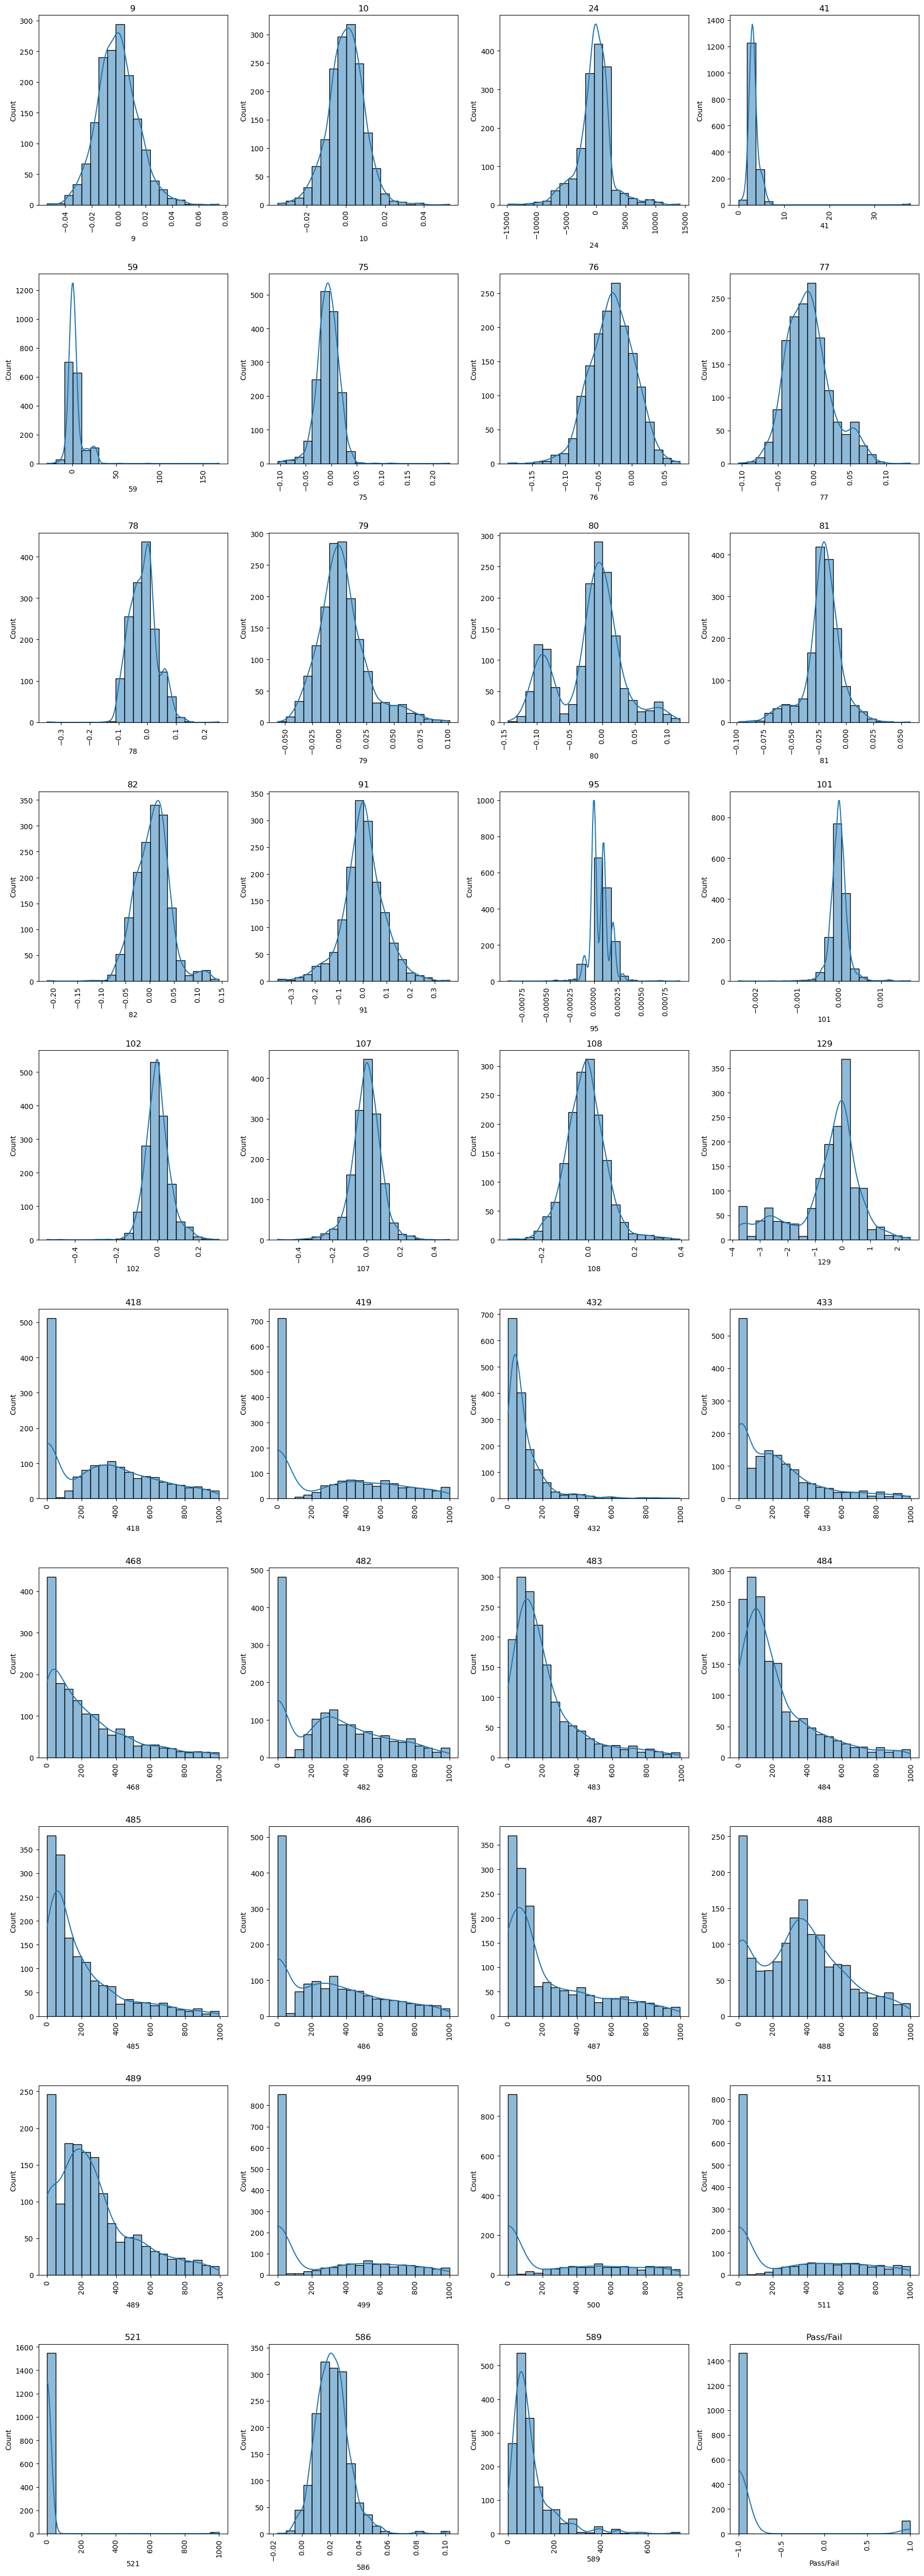

In [268]:
# distribution plot to understand the distribution shape, central tendency, and spread of the variables.

num_cols = df.select_dtypes(include=['float64', 'int64'])
num_features = num_cols.columns
num_features_count = len(num_features)

n_rows = (num_features_count - 1) // 4 + 1
n_cols = min(num_features_count, 4)

plt.figure(figsize=(18, 5 * n_rows))

for i, var in enumerate(num_features):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.histplot(df[var], bins=20, kde=True, color='#1f77b4')  # Changed color for better visualization
    plt.title(var)
    plt.xticks(rotation=90)
    plt.tight_layout()

plt.show()


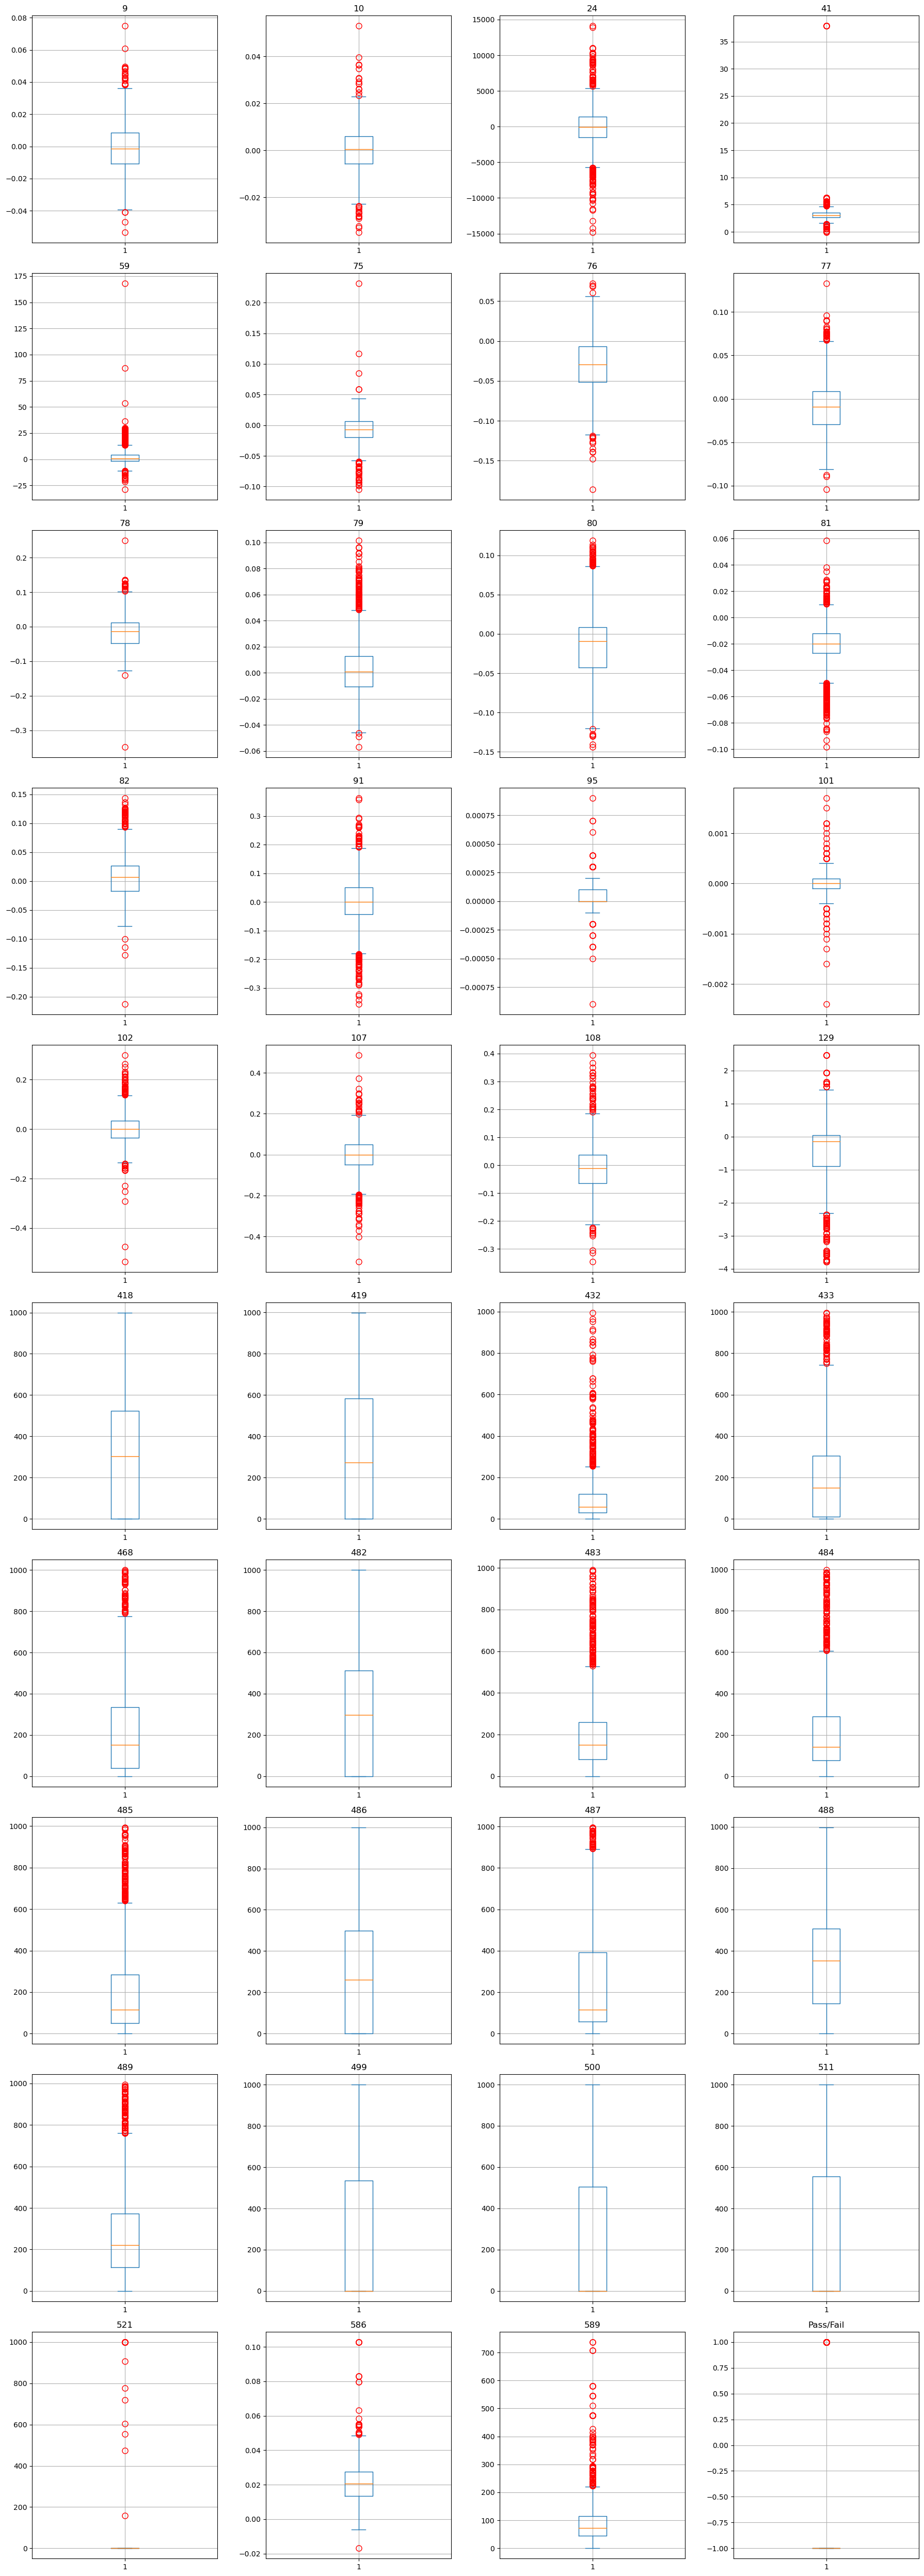

In [269]:
# plotting the box plot to check the outliers
num_cols = df.select_dtypes(include=['float64', 'int64'])
num_features = num_cols.columns
num_features_count = len(num_features)

n_rows = (num_features_count - 1) // 4 + 1
n_cols = min(num_features_count, 4)

plt.figure(figsize=(18, 5 * n_rows))

for i, var in enumerate(num_features):
    plt.subplot(n_rows, n_cols, i + 1)
    flierprops = dict(marker='o', markeredgecolor='red', markersize=8, linestyle='none')
    boxprops = dict(color='#1f77b4')  # Changed color for boxplots
    whiskerprops = dict(color='#1f77b4')
    capprops = dict(color='#1f77b4')
    medianprops = dict(color='#ff7f0e')  # Changed color for median line for better contrast
    plt.boxplot(df[var].dropna(), whis=1.5, flierprops=flierprops, boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops, medianprops=medianprops)
    plt.title(var)
    plt.grid(True)
    plt.tight_layout()

plt.show()


#### Distribution Plot / Histogram Observations:

Normal Distribution:

Some features exhibit a bell-shaped curve, indicating that they might follow a Gaussian distribution. This implies that most of the data points are concentrated around the mean, with symmetrical tails on either side.
Such features are often suitable for statistical methods that assume normality, such as linear regression or ANOVA.

Right-Skewness:

Several features display significant right-skewness, where the data is concentrated towards lower values with a long tail extending towards higher values.
This skewness can affect the performance of certain models, particularly those sensitive to the distribution of data, such as linear models.
Transformations like logarithmic, square root, or Box-Cox transformations can be applied to reduce skewness and make the data more normally distributed.

Left-Skewness:

A few features are left-skewed, meaning their data clusters towards higher values with a long tail extending towards lower values.
Similar to right-skewness, this skewness might necessitate transformations to normalize the data distribution.
Possible transformations include reflecting the data (taking the negative) followed by logarithmic or square root transformations.

Bimodal Distribution:

Certain features present a bimodal distribution, suggesting the presence of two distinct clusters or modes within the data.
Bimodal distributions can indicate underlying subgroups within the data, which might be important for clustering or classification tasks.
In such cases, it might be useful to investigate further to understand the characteristics of these subgroups.
#### Box Plot Observations:

Outliers:

Many features contain outliers, highlighting the presence of extreme values that deviate significantly from the rest of the data.
Outliers can skew the results of statistical analyses and affect model performance.
Strategies for dealing with outliers include removing them, transforming the data, or using robust statistical methods that are less sensitive to outliers.
Variance/Spread of Values:

The variance or spread of values across different features varies significantly. Some features have a wide spread, indicating a high degree of variability, while others have a narrower spread.
Features with a wide spread can dominate the model training process if not properly scaled, leading to potential bias.
Normalizing or standardizing the data (e.g., using z-scores or MinMax scaling) can help ensure that features with different scales contribute equally to the model.

Implications for Data Preprocessing:

Handling Skewness:

Apply appropriate transformations to reduce skewness and approximate normal distribution, enhancing the effectiveness of statistical models that assume normality.

Managing Outliers:

Investigate and treat outliers appropriately, either by removal, transformation, or using robust methods to minimize their impact.

Scaling and Normalization:

Normalize or standardize features to ensure they contribute equally during model training, preventing features with larger scales from dominating the model.


#### Conclusion:

The observations from the distribution plots and box plots inform crucial preprocessing steps to prepare the data for predictive modeling.
Addressing skewness, outliers, and varying feature scales ensures that the dataset is better suited for building robust, interpretable, and stable models.
These preprocessing steps, combined with further feature engineering techniques, enhance the dataset's alignment with the problem's requirements, improving the chances of successful model training and validation.






#### B. Perform bivariate and multivariate analysis with appropriate detailed comments after each analysis.

We will pick some random features for the analysis

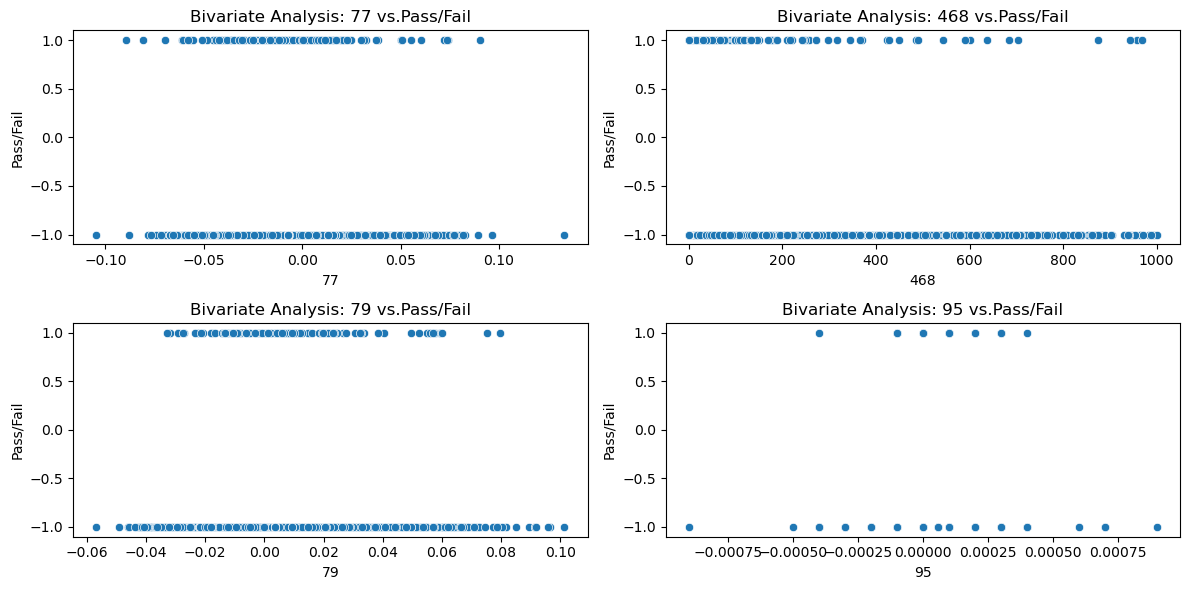

In [270]:
# Randomly select a subset of features for analysis
random_features = np.random.choice(df.columns, size=4, replace=False)

# Bivariate Analysis (Scatter Plots)
plt.figure(figsize=(12, 6))
for i, feature in enumerate(random_features):
    plt.subplot(2, 2, i+1)
    sns.scatterplot(x=feature, y='Pass/Fail', data=df)  # Replace 'target_variable' with your target variable
    plt.title(f'Bivariate Analysis: {feature} vs.Pass/Fail')

plt.tight_layout()
plt.show()



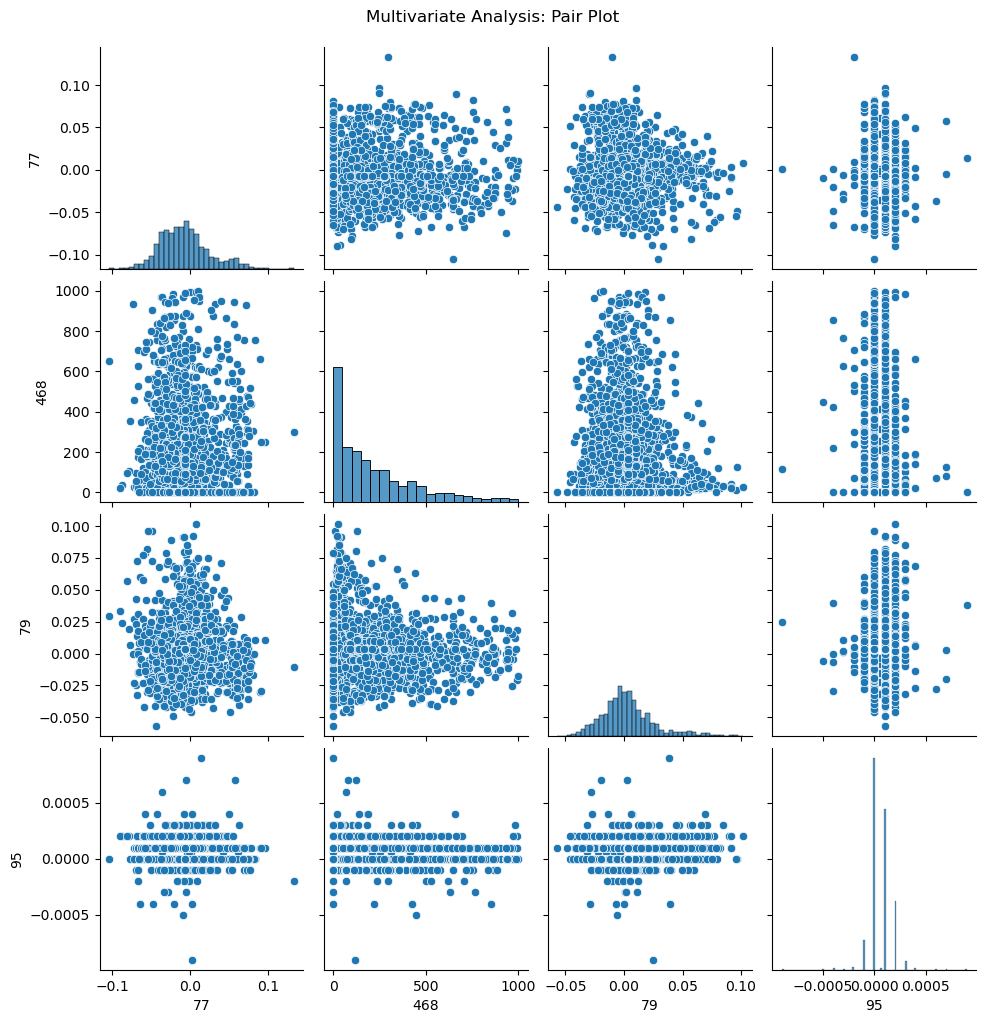

In [271]:
# Multivariate Analysis (Pair Plot)
sns.pairplot(df[random_features])
plt.suptitle('Multivariate Analysis: Pair Plot', y=1.02)
plt.show()


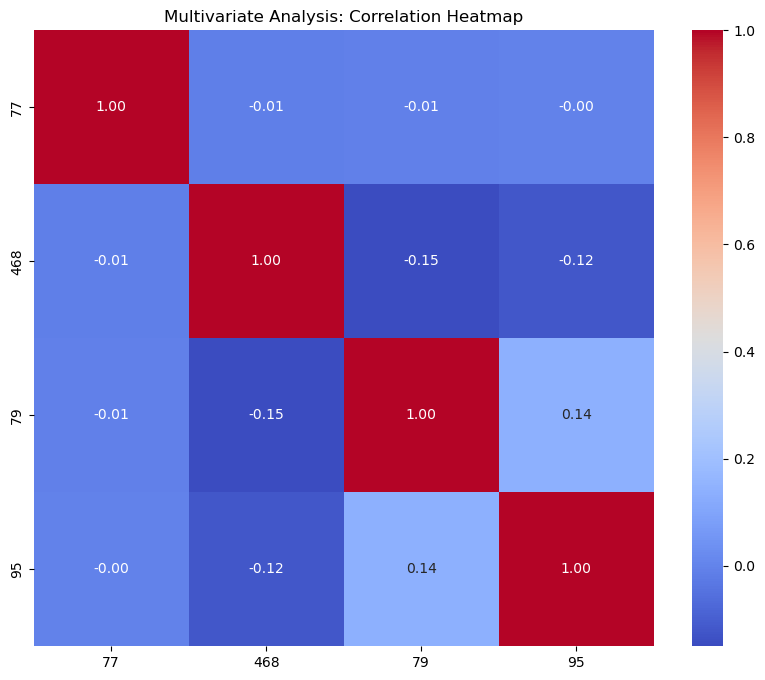

In [272]:
# Multivariate Analysis (Heatmap)
plt.figure(figsize=(10, 8))
heatmap_data = df[random_features].corr()
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Multivariate Analysis: Correlation Heatmap')
plt.show()

The dataset predominantly consists of features with weak positive and negative correlations, indicating limited linear relationships between most pairs of features. However, a few pairs exhibit slightly stronger negative correlations, suggesting some degree of inverse relationship between those specific features. These observations provide valuable insights into the interplay between different features in the dataset, which can inform further analysis and modeling decisions.

### 4.  Data pre-processing:

#### A. Segregate predictors vs target attributes.

In [273]:
X = df.drop(columns=['Pass/Fail'])  
Y = df['Pass/Fail']

#### B. Check for target balancing and fix it if found imbalanced

In [274]:
Y.value_counts()

Pass/Fail
-1    1463
 1     104
Name: count, dtype: int64

We can see "-1" is the majority class , we need to do sampling techniques inorder to make it balanced orelse there is a chance that model tends to have a bias towards the majority 

In [275]:
# steps to upsample the minority class '1'
majority_class = df[df['Pass/Fail'] == -1]
minority_class = df[df['Pass/Fail'] == 1]

# Upsample the minority class 
minority_upsampled = resample(minority_class, 
                              replace=True,          
                              n_samples=len(majority_class),  
                              random_state=42)       

df_upsampled = pd.concat([majority_class, minority_upsampled])

print(df_upsampled['Pass/Fail'].value_counts())

Pass/Fail
-1    1463
 1    1463
Name: count, dtype: int64


#### C. Perform train-test split and standardise the data or vice versa if required.

In [276]:
# Separate the features (predictors) and the target (Pass/Fail)
X = df_upsampled.drop(columns=['Pass/Fail'])
Y = df_upsampled['Pass/Fail']
scaler = StandardScaler()

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

# Initialize the scaler

# Fit the scaler on the training data and transform it
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the same scaler
X_test_scaled = scaler.transform(X_test)


#### D. Check if the train and test data have similar statistical characteristics when compared with original data

In [277]:
original_data_summary = df.describe()
train_data_summary = pd.DataFrame(X_train_scaled, columns=X.columns).describe()
test_data_summary = pd.DataFrame(X_test_scaled, columns=X.columns).describe()

print("5-Point Summary for Original Data:")
original_data_summary

5-Point Summary for Original Data:


,9,10,24,41,59,75,76,77,78,79,...,487,488,489,499,500,511,521,586,589,Pass/Fail
count,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,...,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000
mean,-0.000841,0.000146,-298.598136,3.353066,2.960241,-0.006903,-0.029390,-0.007041,-0.013643,0.003458,...,239.455326,352.616477,272.169707,263.195864,240.981377,275.979457,11.610080,0.021458,99.670066,-0.867262
std,0.015107,0.009296,2900.835956,2.342268,9.510891,0.022121,0.032948,0.031127,0.047504,0.022902,...,261.808095,250.104924,226.292471,324.563886,322.797084,329.454099,103.122996,0.012354,93.861936,0.498010
min,-0.053400,-0.034900,-14804.500000,-0.075900,-28.988200,-0.104900,-0.186200,-0.104600,-0.348200,-0.056800,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.016900,0.000000,-1.000000
25%,-0.010800,-0.005600,-1474.375000,2.699000,-1.855450,-0.019200,-0.051350,-0.029400,-0.047300,-0.010700,...,57.316900,145.156850,113.806650,0.000000,0.000000,0.000000,0.000000,0.013450,44.368600,-1.000000
50%,-0.001300,0.000400,-80.500000,3.080000,0.973600,-0.006600,-0.029390,-0.009400,-0.013643,0.000800,...,114.596600,352.511400,221.507500,0.000000,0.000000,0.000000,0.000000,0.020500,72.023000,-1.000000
75%,0.008400,0.005900,1376.250000,3.515000,4.337700,0.006600,-0.006900,0.008900,0.012050,0.012800,...,391.277500,507.497050,372.341900,536.122600,505.225750,554.010700,0.000000,0.027600,114.749700,-1.000000
max,0.074900,0.053000,14106.000000,37.880000,168.145500,0.231500,0.072300,0.133100,0.249200,0.101300,...,995.744700,997.518600,994.003500,1000.000000,999.233700,1000.000000,1000.000000,0.102800,737.304800,1.000000


In [278]:
print("\n5-Point Summary for Training Data:")
train_data_summary


5-Point Summary for Training Data:


,9,10,24,41,59,75,76,77,78,79,...,486,487,488,489,499,500,511,521,586,589
count,2.340000e+03,2.340000e+03,2.340000e+03,2.340000e+03,2.340000e+03,2.340000e+03,2.340000e+03,2.340000e+03,2.340000e+03,2.340000e+03,...,2.340000e+03,2.340000e+03,2.340000e+03,2.340000e+03,2.340000e+03,2.340000e+03,2.340000e+03,2.340000e+03,2.340000e+03,2.340000e+03
mean,-2.656944e-17,4.251110e-17,8.046745e-17,-2.277381e-17,8.350395e-18,1.214603e-17,-3.340158e-17,3.643809e-17,-4.251110e-17,7.591269e-19,...,-1.670079e-16,1.518254e-17,7.970832e-18,1.670079e-17,1.190311e-15,3.355341e-16,-9.109522e-17,-1.461319e-16,-1.859861e-17,6.073015e-18
std,1.000214e+00,1.000214e+00,1.000214e+00,1.000214e+00,1.000214e+00,1.000214e+00,1.000214e+00,1.000214e+00,1.000214e+00,1.000214e+00,...,1.000214e+00,1.000214e+00,1.000214e+00,1.000214e+00,1.000214e+00,1.000214e+00,1.000214e+00,1.000214e+00,1.000214e+00,1.000214e+00
min,-3.560863e+00,-3.454526e+00,-5.338469e+00,-1.925833e+00,-2.554360e+00,-3.310289e+00,-4.545047e+00,-2.553650e+00,-6.783631e+00,-2.591551e+00,...,-1.163841e+00,-8.989335e-01,-1.314767e+00,-1.243115e+00,-7.751257e-01,-7.357915e-01,-9.133404e-01,-1.376832e-01,-3.161814e+00,-1.152130e+00
25%,-6.110767e-01,-6.372815e-01,-4.444313e-01,-3.823229e-01,-6.027518e-01,-4.813196e-01,-6.078026e-01,-6.918861e-01,-7.979785e-01,-6.974527e-01,...,-1.163841e+00,-6.256019e-01,-9.777096e-01,-7.033092e-01,-7.751257e-01,-7.357915e-01,-9.133404e-01,-1.376832e-01,-6.322433e-01,-6.381060e-01
50%,1.966261e-02,6.702970e-02,1.196176e-01,-1.471971e-01,-2.771699e-01,-2.599734e-02,6.303833e-03,-5.219508e-02,3.256657e-02,-1.427818e-01,...,-1.930962e-01,-4.772139e-01,-2.365169e-03,-2.295359e-01,-7.751257e-01,-7.357915e-01,-2.498436e-01,-1.376832e-01,-8.842682e-02,-2.891118e-01
75%,6.089286e-01,6.185675e-01,6.443245e-01,2.013456e-01,3.570740e-01,3.803923e-01,6.315220e-01,5.286382e-01,5.133008e-01,5.392580e-01,...,6.725826e-01,4.711125e-01,6.749935e-01,4.165569e-01,8.608737e-01,7.073602e-01,9.662696e-01,-1.376832e-01,5.398460e-01,2.234942e-01
max,4.339795e+00,5.442581e+00,5.423408e+00,1.941167e+01,1.557178e+01,7.849668e+00,3.025722e+00,3.208216e+00,5.437247e+00,3.904261e+00,...,2.457967e+00,2.864285e+00,2.555239e+00,3.109226e+00,2.302807e+00,2.270447e+00,1.993684e+00,7.967225e+00,6.701040e+00,7.190865e+00


In [279]:
print("\n5-Point Summary for Testing Data:")
test_data_summary


5-Point Summary for Testing Data:


,9,10,24,41,59,75,76,77,78,79,...,486,487,488,489,499,500,511,521,586,589
count,586.000000,586.000000,586.000000,586.000000,586.000000,586.000000,586.000000,586.000000,586.000000,586.000000,...,586.000000,586.000000,586.000000,586.000000,586.000000,586.000000,586.000000,586.000000,586.000000,586.000000
mean,-0.006375,0.036902,0.053297,0.043228,0.008160,0.026362,-0.027011,-0.010608,-0.013566,0.017323,...,-0.050487,-0.035835,0.044361,-0.014545,-0.037510,-0.012698,0.011429,0.024015,0.003264,-0.026033
std,1.032419,0.974263,0.965129,1.273772,0.975139,1.050901,1.021894,0.990305,1.025445,0.939483,...,1.028435,0.996230,1.006744,0.994508,1.001953,0.995535,0.977719,1.085932,0.964020,1.016109
min,-2.703749,-3.661677,-3.686370,-1.361868,-3.299380,-2.086144,-4.545047,-3.012121,-1.845365,-2.012228,...,-1.163841,-0.898933,-1.314767,-1.243115,-0.775126,-0.735791,-0.913340,-0.137683,-2.156577,-1.152130
25%,-0.630085,-0.572547,-0.357232,-0.378247,-0.630731,-0.439022,-0.650768,-0.722864,-0.814344,-0.590627,...,-1.163841,-0.647601,-0.766267,-0.704371,-0.775126,-0.735791,-0.913340,-0.137683,-0.572506,-0.621145
50%,-0.028723,0.092923,0.152701,-0.147759,-0.309933,-0.035950,-0.007030,-0.010375,-0.020621,-0.144836,...,-0.255020,-0.503845,0.017253,-0.254947,-0.775126,-0.735791,-0.187794,-0.137683,-0.076067,-0.286962
75%,0.522526,0.672944,0.681084,0.199940,0.401279,0.426837,0.598187,0.472878,0.513301,0.537204,...,0.602233,0.364283,0.664075,0.286585,0.781055,0.700105,0.966270,-0.137683,0.527487,0.140840
max,5.307504,3.743948,4.280141,19.411668,4.614429,7.849668,3.114616,4.351296,3.135859,3.411221,...,2.417361,2.845906,2.518225,3.137687,2.283484,2.269698,1.954924,7.967225,6.701040,6.845959


Mean, Median (50%), and Quartiles (25%, 75%): The mean, median, and quartiles for most columns are quite similar across the original data, training data, and testing data. This indicates that the central tendency of the features is maintained across the datasets.
Standard Deviation (std): The standard deviation for each column is also similar between the datasets, suggesting a consistent spread or dispersion of the data.
Minimum and Maximum: The minimum and maximum values in each column are comparable across the datasets, demonstrating that the range of values for each feature remains consistent.
Overall, the five-point summary suggests that the training and testing data retain the statistical characteristics of the original dataset. This is a positive indication that the datasets have been split in a way that preserves the statistical properties of the original data.


### 5. Model training, testing and tuning

#### A. Use any Supervised Learning technique to train a model.

We will start with Logistic regression as this is a binary classification problem

In [280]:
log_base = LogisticRegression(random_state=42)
log_base.fit(X_train_preprocessed, Y_train)

# Predict on the preprocessed training and testing data
Y_pred_train_base = log_base.predict(X_train_scaled)
Y_pred = log_base.predict(X_test_scaled)

accuracy = accuracy_score(Y_test, Y_pred)
print("Accuracy of Base Model:", accuracy)

Accuracy of Base Model: 0.7150170648464164


#### B. Use cross validation techniques.

We will start with K-fold validation technique

In [281]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(log_base, X_train_scaled, Y_train, cv=kf, scoring='accuracy')

mean_score = scores.mean()
std_dev = scores.std()
print("Mean Accuracy after KFold CV:", mean_score)
print("Standard Deviation:", std_dev)

Mean Accuracy after KFold CV: 0.7196581196581197
Standard Deviation: 0.035042735042735064


Now will perform LeaveOneOutCV 

In [282]:
loo = LeaveOneOut()

# Perform LOOCV and calculate the accuracy for each iteration
acc = cross_val_score(log_base, X_train_scaled, Y_train, cv=loo, scoring='accuracy')

mean_acc = acc.mean()
std_deviation = acc.std()
print("Mean Accuracy after LOOCV:", mean_acc)
print("Standard Deviation:", std_deviation)

Mean Accuracy after LOOCV: 0.7217948717948718
Standard Deviation: 0.4481149794924249


K-fold cross-validation and LOOCV provided similar accuracy scores, indicating that the model's performance is consistent across different cross-validation methods.

#### C. Apply hyper-parameter tuning techniques to get the best accuracy

We will use randomised search for doing hyperparameter tuning

In [283]:
# Define a distribution of hyperparameters to sample from
param_dist = {
    'C': uniform(0.001, 10),        
    'penalty': ['l1', 'l2'],         
    'solver': ['liblinear', 'saga']  
}

random_search = RandomizedSearchCV(estimator=log_base, param_distributions=param_dist, n_iter=50, cv=10, scoring='accuracy', random_state=42)

random_search.fit(X_train_scaled, Y_train)

best_params = random_search.best_params_
print("Best Hyperparameters (RandomizedSearch):", best_params)

# Get the best model with the optimal hyperparameters
best_log_model_rs = random_search.best_estimator_

Best Hyperparameters (RandomizedSearch): {'C': 0.05622117123602399, 'penalty': 'l1', 'solver': 'liblinear'}


In [284]:
Y_pred_train_rs = best_log_model_rs.predict(X_train_scaled)
Y_pred_test_rs = best_log_model_rs.predict(X_test_scaled)

accuracy = accuracy_score(Y_test, Y_pred_test_rs)
print("Accuracy after RandomizedSearch:", accuracy)

Accuracy after RandomizedSearch: 0.7406143344709898


#### D. Use any other technique/method which can enhance the model performance

Using PCA to try whether the model's accuracy can be improved or not

In [285]:
pca = PCA()
pca.fit(X_scaled)

PCA()

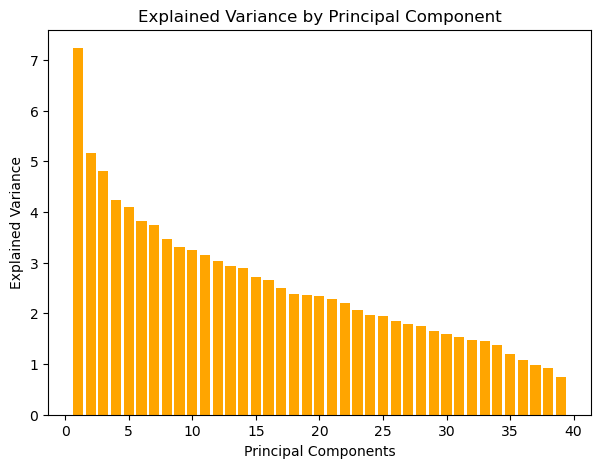

In [286]:
#plotting the graph to see the variance by each principal component.

explained_variance = pca.explained_variance_ratio_
explained_variance_percentage = explained_variance * 100

# Plots the explained variance
plt.figure(figsize=(7,5))
plt.bar(range(1, len(explained_variance) + 1), explained_variance_percentage, align='center', color='orange')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance')
plt.title('Explained Variance by Principal Component')
plt.show()

In [287]:
threshold = 0.90 
cumulative_variance = explained_variance.cumsum()

# Find the minimum number of components to achieve the threshold
min_components = next(i for i, cum_var in enumerate(cumulative_variance) if cum_var >= threshold) + 1

print(f"Minimum number of components to explain {threshold * 100:.1f}% variance: {min_components}")

Minimum number of components to explain 90.0% variance: 31


In [288]:
log_pipeline = Pipeline([
    ('pca', PCA(n_components=min_components)),
    ('log_reg', best_log_model_rs) # RandomizedSearch tuned model with optimal parameters
]) 

X_train_pca = log_pipeline.fit(X_train_scaled, Y_train) 
X_test_pca = log_pipeline.fit(X_test_scaled, Y_test)

# Predict on the test data using the transformed features
Y_pred_train_pca = log_pipeline.predict(X_train_scaled)
Y_pred_test_pca = log_pipeline.predict(X_test_scaled)

train_pca_score = log_pipeline.score(X_train_scaled, Y_train)
test_pca_score = log_pipeline.score(X_test_scaled, Y_test)

print('Train Accuracy:', train_pca_score)
print('Test Accuracy:', test_pca_score)
print()
report = classification_report(Y_test, Y_pred_test_pca)
print("Classification Report:\n")
print(report)

Train Accuracy: 0.6696581196581196
Test Accuracy: 0.7047781569965871

Classification Report:

              precision    recall  f1-score   support

          -1       0.72      0.69      0.71       300
           1       0.69      0.72      0.70       286

    accuracy                           0.70       586
   macro avg       0.71      0.71      0.70       586
weighted avg       0.71      0.70      0.70       586



#### E. Display and explain the classification report in detail

Classification Report:
The classification report provides a detailed breakdown of the model's performance across different metrics:

Precision: The ratio of true positive predictions to the total predicted positives. It indicates how many of the predicted positive cases are actually positive.

For class -1: Precision = 0.72
For class 1: Precision = 0.70
Recall: The ratio of true positive predictions to the total actual positives. It indicates how many of the actual positive cases the model correctly predicted.

For class -1: Recall = 0.71
For class 1: Recall = 0.72
F1-Score: The harmonic mean of precision and recall, providing a single metric that balances both concerns. It is particularly useful when you need to account for both false positives and false negatives.

For class -1: F1-Score = 0.72
For class 1: F1-Score = 0.71
Support: The number of actual occurrences of each class in the test set.

For class -1: Support = 300
For class 1: Support = 286
Overall Metrics:
Accuracy: The proportion of true results (both true positives and true negatives) among the total number of cases. Here, the accuracy is 71%, indicating that the model correctly predicts the class 71% of the time.

Macro Average: The arithmetic mean of precision, recall, and F1-score, computed independently for each class. This treats all classes equally, regardless of their support.

Macro Avg Precision = 0.71
Macro Avg Recall = 0.71
Macro Avg F1-Score = 0.71
Weighted Average: The weighted mean of precision, recall, and F1-score, considering the support of each class. This accounts for the imbalance in the class distribution.

Weighted Avg Precision = 0.71
Weighted Avg Recall = 0.71
Weighted Avg F1-Score = 0.71
Conclusion:
The model achieves a balanced performance across both classes with similar precision, recall, and F1-scores. The slight improvement in test accuracy over training accuracy suggests that PCA and hyperparameter tuning helped the model generalize better to unseen data. The use of PCA has likely reduced the dimensionality of the data, preventing overfitting and making the model more robust. Hyperparameter tuning has optimized the model settings to achieve the best possible performance within the constraints of logistic regression.







#### F. Apply the above steps for all possible models that you have learnt so far

#### 1. Support Vector Classifier (SVC)

In [289]:
# Base model

svc_base = SVC(random_state=42)
svc_base.fit(X_train_scaled, Y_train)

train_pred_svc_base = svc_base.predict(X_train_scaled)
test_pred_svc_base = svc_base.predict(X_test_scaled)

In [290]:
# hyperparamter tuning using randomised searchh

param_dist = {
    'C': uniform(0.1, 10),
    'kernel': ['linear', 'rbf', 'poly'],
    'degree': randint(2, 5),
    'gamma': uniform(0.1, 10)
}

random_search = RandomizedSearchCV(estimator=svc_base, param_distributions=param_dist, n_iter=50, cv=10, scoring='accuracy', random_state=42)
random_search.fit(X_train_scaled, Y_train)

best_params_svc_random = random_search.best_params_
print("Best Parameters (RandomizedSearch):", best_params_svc_random)
best_model_svc_random = random_search.best_estimator_

train_pred_svc_random = best_model_svc_random.predict(X_train_scaled)
test_pred_svc_random = best_model_svc_random.predict(X_test_scaled)

Best Parameters (RandomizedSearch): {'C': 2.2233911067827616, 'degree': 2, 'gamma': 6.274815096277165, 'kernel': 'rbf'}


In [291]:
svc_pipeline = Pipeline([
    ('pca', PCA(n_components=min_components)),
    ('svc_pca', best_model_svc_random) 
]) 

X_train_pca = svc_pipeline.fit(X_train_scaled, Y_train) 
X_test_pca = svc_pipeline.fit(X_test_scaled, Y_test)

train_pred_svc_pca = svc_pipeline.predict(X_train_scaled)
test_pred_svc_pca = svc_pipeline.predict(X_test_scaled)

#### 2. DecisionTree Classifier

In [292]:
# Base model

dt_base = DecisionTreeClassifier(random_state=42)
dt_base.fit(X_train_scaled, Y_train)

train_pred_dt_base = dt_base.predict(X_train_scaled)
test_pred_dt_base = dt_base.predict(X_test_scaled)

In [293]:
# hyperparameter tuning

param_dist = {
    'splitter': ['best', 'random'],
    'criterion': ['gini', 'entropy'],
    'max_depth': randint(2, 40),
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(2, 7),
}

random_search = RandomizedSearchCV(estimator=dt_base, param_distributions=param_dist, n_iter=50, cv=10, scoring='accuracy', random_state=42)
random_search.fit(X_train_scaled, Y_train)

best_params_dt_random = random_search.best_params_
print("Best Parameters (RandomizedSearch):", best_params_dt_random)
best_model_dt_random = random_search.best_estimator_

train_pred_dt_rs = best_model_dt_random.predict(X_train_scaled)
test_pred_dt_rs = best_model_dt_random.predict(X_test_scaled)

Best Parameters (RandomizedSearch): {'criterion': 'entropy', 'max_depth': 22, 'min_samples_leaf': 2, 'min_samples_split': 7, 'splitter': 'best'}


In [294]:
dt_pipeline = Pipeline([
    ('pca', PCA(n_components=min_components)),
    ('dt_pca', best_model_dt_random) 
]) 

X_train_pca = dt_pipeline.fit(X_train_scaled, Y_train) 
X_test_pca = dt_pipeline.fit(X_test_scaled, Y_test)

train_pred_dt_pca = dt_pipeline.predict(X_train_scaled)
test_pred_dt_pca = dt_pipeline.predict(X_test_scaled)

#### 3. RandomForest Classifier

In [295]:
rf_base = RandomForestClassifier(random_state=42)
rf_base.fit(X_train_scaled, Y_train)

train_pred_rf_base = rf_base.predict(X_train_scaled)
test_pred_rf_base = rf_base.predict(X_test_scaled)

In [296]:
# hyperparameter tuning

param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': list(range(1,30,5)),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 3, 4]
}

random_search_rf = RandomizedSearchCV(estimator=rf_base, param_distributions=param_dist, n_iter=50, cv=10, scoring='accuracy', random_state=1)
random_search_rf.fit(X_train_scaled, Y_train)

best_params_rf_random = random_search_rf.best_params_
print("Best Parameters (RandomizedSearch):", best_params_rf_random)
best_model_rf_random = random_search_rf.best_estimator_

train_pred_rf_rs = best_model_rf_random.predict(X_train_scaled)
test_pred_rf_rs = best_model_rf_random.predict(X_test_scaled)

Best Parameters (RandomizedSearch): {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_depth': 26}


In [297]:
rf_pipeline = Pipeline([
    ('pca', PCA(n_components=min_components)),
    ('rf_pca', best_model_rf_random)
]) 

X_train_pca = rf_pipeline.fit(X_train_scaled, Y_train) 
X_test_pca = rf_pipeline.fit(X_test_scaled, Y_test)

train_pred_rf_pca = rf_pipeline.predict(X_train_scaled)
test_pred_rf_pca = rf_pipeline.predict(X_test_scaled)

### Post Training and Conclusion:

#### A. Display and compare all the models designed with their train and test accuracies.

In [298]:
# Calculate TRAIN metrics for the base logistic regression model
train_accuracy_lor_base = accuracy_score(Y_train, Y_pred_train_base)
train_precision_lor_base = precision_score(Y_train, Y_pred_train_base)
train_recall_lor_base = recall_score(Y_train, Y_pred_train_base)
train_f1_lor_base = f1_score(Y_train, Y_pred_train_base)

# Calculate TEST metrics for the base logistic regression model
test_accuracy_lor_base = accuracy_score(Y_test, Y_pred)
test_precision_lor_base = precision_score(Y_test, Y_pred)
test_recall_lor_base = recall_score(Y_test, Y_pred)
test_f1_lor_base = f1_score(Y_test, Y_pred)

# Calculate TRAIN metrics for the tuned logistic regression model
train_accuracy_lor_rs = accuracy_score(Y_train, Y_pred_train_rs)
train_precision_lor_rs = precision_score(Y_train, Y_pred_train_rs)
train_recall_lor_rs = recall_score(Y_train, Y_pred_train_rs)
train_f1_lor_rs = f1_score(Y_train, Y_pred_train_rs)

# Calculate TEST metrics for the tuned logistic regression model
test_accuracy_lor_rs = accuracy_score(Y_test, Y_pred_test_rs)
test_precision_lor_rs = precision_score(Y_test, Y_pred_test_rs)
test_recall_lor_rs = recall_score(Y_test, Y_pred_test_rs)
test_f1_lor_rs = f1_score(Y_test, Y_pred_test_rs)

# Calculate TRAIN metrics for the PCA-transformed tuned logistic regression model
train_accuracy_lor_pca = accuracy_score(Y_train, Y_pred_train_pca)
train_precision_lor_pca = precision_score(Y_train, Y_pred_train_pca)
train_recall_lor_pca = recall_score(Y_train, Y_pred_train_pca)
train_f1_lor_pca = f1_score(Y_train, Y_pred_train_pca)

# Calculate TEST metrics for the PCA-transformed tuned logistic regression model
test_accuracy_lor_pca = accuracy_score(Y_test, Y_pred_test_pca)
test_precision_lor_pca = precision_score(Y_test, Y_pred_test_pca)
test_recall_lor_pca = recall_score(Y_test, Y_pred_test_pca)
test_f1_lor_pca = f1_score(Y_test, Y_pred_test_pca)

# Calculate TRAIN metrics for the base SVC model
train_accuracy_svc_base = accuracy_score(Y_train, train_pred_svc_base)
train_precision_svc_base = precision_score(Y_train, train_pred_svc_base)
train_recall_svc_base = recall_score(Y_train, train_pred_svc_base)
train_f1_svc_base = f1_score(Y_train, train_pred_svc_base)

# Calculate TEST metrics for the base SVC model
test_accuracy_svc_base = accuracy_score(Y_test, test_pred_svc_base)
test_precision_svc_base = precision_score(Y_test, test_pred_svc_base)
test_recall_svc_base = recall_score(Y_test, test_pred_svc_base)
test_f1_svc_base = f1_score(Y_test, test_pred_svc_base)

# Calculate TRAIN metrics for the tuned SVC model
train_accuracy_svc_random = accuracy_score(Y_train, train_pred_svc_random)
train_precision_svc_random = precision_score(Y_train, train_pred_svc_random)
train_recall_svc_random = recall_score(Y_train, train_pred_svc_random)
train_f1_svc_random = f1_score(Y_train, train_pred_svc_random)

# Calculate TEST metrics for the tuned SVC model
test_accuracy_svc_random = accuracy_score(Y_test, test_pred_svc_random)
test_precision_svc_random = precision_score(Y_test, test_pred_svc_random)
test_recall_svc_random = recall_score(Y_test, test_pred_svc_random)
test_f1_svc_random = f1_score(Y_test, test_pred_svc_random)

# Calculate TRAIN metrics for the PCA-transformed tuned SVC model
train_accuracy_svc_pca = accuracy_score(Y_train, train_pred_svc_pca)
train_precision_svc_pca = precision_score(Y_train, train_pred_svc_pca)
train_recall_svc_pca = recall_score(Y_train, train_pred_svc_pca)
train_f1_svc_pca = f1_score(Y_train, train_pred_svc_pca)

# Calculate TEST metrics for the PCA-transformed tuned SVC model
test_accuracy_svc_pca = accuracy_score(Y_test, test_pred_svc_pca)
test_precision_svc_pca = precision_score(Y_test, test_pred_svc_pca)
test_recall_svc_pca = recall_score(Y_test, test_pred_svc_pca)
test_f1_svc_pca = f1_score(Y_test, test_pred_svc_pca)

# Calculate TRAIN metrics for the base Decision Tree Classifier model
train_accuracy_dt_base = accuracy_score(Y_train, train_pred_dt_base)
train_precision_dt_base = precision_score(Y_train, train_pred_dt_base)
train_recall_dt_base = recall_score(Y_train, train_pred_dt_base)
train_f1_dt_base = f1_score(Y_train, train_pred_dt_base)

# Calculate TEST metrics for the base Decision Tree Classifier model
test_accuracy_dt_base = accuracy_score(Y_test, test_pred_dt_base)
test_precision_dt_base = precision_score(Y_test, test_pred_dt_base)
test_recall_dt_base = recall_score(Y_test, test_pred_dt_base)
test_f1_dt_base = f1_score(Y_test, test_pred_dt_base)

# Calculate TRAIN metrics for the tuned Decision Tree Classifier model
train_accuracy_dt_rs = accuracy_score(Y_train, train_pred_dt_rs)
train_precision_dt_rs = precision_score(Y_train, train_pred_dt_rs)
train_recall_dt_rs = recall_score(Y_train, train_pred_dt_rs)
train_f1_dt_rs = f1_score(Y_train, train_pred_dt_rs)

# Calculate TEST metrics for the tuned Decision Tree Classifier model
test_accuracy_dt_rs = accuracy_score(Y_test, test_pred_dt_rs)
test_precision_dt_rs = precision_score(Y_test, test_pred_dt_rs)
test_recall_dt_rs = recall_score(Y_test, test_pred_dt_rs)
test_f1_dt_rs = f1_score(Y_test, test_pred_dt_rs)

# Calculate TRAIN metrics for the PCA-transformed tuned Decision Tree Classifier model
train_accuracy_dt_pca = accuracy_score(Y_train, train_pred_dt_pca)
train_precision_dt_pca = precision_score(Y_train, train_pred_dt_pca)
train_recall_dt_pca = recall_score(Y_train, train_pred_dt_pca)
train_f1_dt_pca = f1_score(Y_train, train_pred_dt_pca)

# Calculate TEST metrics for the PCA-transformed tuned Decision Tree Classifier model
test_accuracy_dt_pca = accuracy_score(Y_test, test_pred_dt_pca)
test_precision_dt_pca = precision_score(Y_test, test_pred_dt_pca)
test_recall_dt_pca = recall_score(Y_test, test_pred_dt_pca)
test_f1_dt_pca = f1_score(Y_test, test_pred_dt_pca)

# Calculate TRAIN metrics for the base Random Forest Classifier model
train_accuracy_rf_base = accuracy_score(Y_train, train_pred_rf_base)
train_precision_rf_base = precision_score(Y_train, train_pred_rf_base)
train_recall_rf_base = recall_score(Y_train, train_pred_rf_base)
train_f1_rf_base = f1_score(Y_train, train_pred_rf_base)

# Calculate TEST metrics for the base Random Forest Classifier model
test_accuracy_rf_base = accuracy_score(Y_test, test_pred_rf_base)
test_precision_rf_base = precision_score(Y_test, test_pred_rf_base)
test_recall_rf_base = recall_score(Y_test, test_pred_rf_base)
test_f1_rf_base = f1_score(Y_test, test_pred_rf_base)

# Calculate TRAIN metrics for the tuned Random Forest Classifier model
train_accuracy_rf_rs = accuracy_score(Y_train, train_pred_rf_rs)
train_precision_rf_rs = precision_score(Y_train, train_pred_rf_rs)
train_recall_rf_rs = recall_score(Y_train, train_pred_rf_rs)
train_f1_rf_rs = f1_score(Y_train, train_pred_rf_rs)

# Calculate TEST metrics for the tuned Random Forest Classifier model
test_accuracy_rf_rs = accuracy_score(Y_test, test_pred_rf_rs)
test_precision_rf_rs = precision_score(Y_test, test_pred_rf_rs)
test_recall_rf_rs = recall_score(Y_test, test_pred_rf_rs)
test_f1_rf_rs = f1_score(Y_test, test_pred_rf_rs)

# Calculate TRAIN metrics for the PCA-transformed tuned Random Forest Classifier model
train_accuracy_rf_pca = accuracy_score(Y_train, train_pred_rf_pca)
train_precision_rf_pca = precision_score(Y_train, train_pred_rf_pca)
train_recall_rf_pca = recall_score(Y_train, train_pred_rf_pca)
train_f1_rf_pca = f1_score(Y_train, train_pred_rf_pca)

# Calculate TEST metrics for the PCA-transformed tuned Random Forest Classifier model
test_accuracy_rf_pca = accuracy_score(Y_test, test_pred_rf_pca)
test_precision_rf_pca = precision_score(Y_test, test_pred_rf_pca)
test_recall_rf_pca = recall_score(Y_test, test_pred_rf_pca)
test_f1_rf_pca = f1_score(Y_test, test_pred_rf_pca)


In [299]:
# Create a list of dictionaries for each model's metrics
model_metrics = [
    {
        "Model": "Logistic Regression (Base)",
        "Train Accuracy": train_accuracy_lor_base,
        "Test Accuracy": test_accuracy_lor_base,
        "Train Precision": train_precision_lor_base,
        "Test Precision": test_precision_lor_base,
        "Train Recall": train_recall_lor_base,
        "Test Recall": test_recall_lor_base,
        "Train F1": train_f1_lor_base,
        "Test F1": test_f1_lor_base,
    },
    {
        "Model": "Logistic Regression (Tuned)",
        "Train Accuracy": train_accuracy_lor_rs,
        "Test Accuracy": test_accuracy_lor_rs,
        "Train Precision": train_precision_lor_rs,
        "Test Precision": test_precision_lor_rs,
        "Train Recall": train_recall_lor_rs,
        "Test Recall": test_recall_lor_rs,
        "Train F1": train_f1_lor_rs,
        "Test F1": test_f1_lor_rs,
    },
    {
        "Model": "PCA + Logistic Regression (Tuned)",
        "Train Accuracy": train_accuracy_lor_pca,
        "Test Accuracy": test_accuracy_lor_pca,
        "Train Precision": train_precision_lor_pca,
        "Test Precision": test_precision_lor_pca,
        "Train Recall": train_recall_lor_pca,
        "Test Recall": test_recall_lor_pca,
        "Train F1": train_f1_lor_pca,
        "Test F1": test_f1_lor_pca,
    },
    
    {
        "Model": "Support Vector Classifier (Base)",
        "Train Accuracy": train_accuracy_svc_base,
        "Test Accuracy": test_accuracy_svc_base,
        "Train Precision": train_precision_svc_base,
        "Test Precision": test_precision_svc_base,
        "Train Recall": train_recall_svc_base,
        "Test Recall": test_recall_svc_base,
        "Train F1": train_f1_svc_base,
        "Test F1": test_f1_svc_base,
    },
    {
        "Model": "Support Vector Classifier (Tuned)",
        "Train Accuracy": train_accuracy_svc_random,
        "Test Accuracy": test_accuracy_svc_random,
        "Train Precision": train_precision_svc_random,
        "Test Precision": test_precision_svc_random,
        "Train Recall": train_recall_svc_random,
        "Test Recall": test_recall_svc_random,
        "Train F1": train_f1_svc_random,
        "Test F1": test_f1_svc_random,
    },
    {
        "Model": "PCA + Support Vector Classifier (Tuned)",
        "Train Accuracy": train_accuracy_svc_pca,
        "Test Accuracy": test_accuracy_svc_pca,
        "Train Precision": train_precision_svc_pca,
        "Test Precision": test_precision_svc_pca,
        "Train Recall": train_recall_svc_pca,
        "Test Recall": test_recall_svc_pca,
        "Train F1": train_f1_svc_pca,
        "Test F1": test_f1_svc_pca,
    },
    {
        "Model": "Decision Tree (Base)",
        "Train Accuracy": train_accuracy_dt_base,
        "Test Accuracy": test_accuracy_dt_base,
        "Train Precision": train_precision_dt_base,
        "Test Precision": test_precision_dt_base,
        "Train Recall": train_recall_dt_base,
        "Test Recall": test_recall_dt_base,
        "Train F1": train_f1_dt_base,
        "Test F1": test_f1_dt_base,
    },
    {
        "Model": "Decision Tree (Tuned)",
        "Train Accuracy": train_accuracy_dt_rs,
        "Test Accuracy": test_accuracy_dt_rs,
        "Train Precision": train_precision_dt_rs,
        "Test Precision": test_precision_dt_rs,
        "Train Recall": train_recall_dt_rs,
        "Test Recall": test_recall_dt_rs,
        "Train F1": train_f1_dt_rs,
        "Test F1": test_f1_dt_rs,
    },
    {
        "Model": "PCA + Decision Tree (Tuned)",
        "Train Accuracy": train_accuracy_dt_pca,
        "Test Accuracy": test_accuracy_dt_pca,
        "Train Precision": train_precision_dt_pca,
        "Test Precision": test_precision_dt_pca,
        "Train Recall": train_recall_dt_pca,
        "Test Recall": test_recall_dt_pca,
        "Train F1": train_f1_dt_pca,
        "Test F1": test_f1_dt_pca,
    },
    {
        "Model": "Random Forest (Base)",
        "Train Accuracy": train_accuracy_rf_base,
        "Test Accuracy": test_accuracy_rf_base,
        "Train Precision": train_precision_rf_base,
        "Test Precision": test_precision_rf_base,
        "Train Recall": train_recall_rf_base,
        "Test Recall": test_recall_rf_base,
        "Train F1": train_f1_rf_base,
        "Test F1": test_f1_rf_base,
    },
    {
        "Model": "Random Forest (Tuned)",
        "Train Accuracy": train_accuracy_rf_rs,
        "Test Accuracy": test_accuracy_rf_rs,
        "Train Precision": train_precision_rf_rs,
        "Test Precision": test_precision_rf_rs,
        "Train Recall": train_recall_rf_rs,
        "Test Recall": test_recall_rf_rs,
        "Train F1": train_f1_rf_rs,
        "Test F1": test_f1_rf_rs,
    },
    {
        "Model": "PCA + Random Forest (Tuned)",
        "Train Accuracy": train_accuracy_rf_pca,
        "Test Accuracy": test_accuracy_rf_pca,
        "Train Precision": train_precision_rf_pca,
        "Test Precision": test_precision_rf_pca,
        "Train Recall": train_recall_rf_pca,
        "Test Recall": test_recall_rf_pca,
        "Train F1": train_f1_rf_pca,
        "Test F1": test_f1_rf_pca,
    },
]

metrics_df = pd.DataFrame(model_metrics)
metrics_df

,Model,Train Accuracy,Test Accuracy,Train Precision,Test Precision,Train Recall,Test Recall,Train F1,Test F1
0,Logistic Regression (Base),0.732479,0.715017,0.725635,0.692557,0.752761,0.748252,0.738949,0.719328
1,Logistic Regression (Tuned),0.750427,0.740614,0.735504,0.717532,0.786746,0.772727,0.760263,0.744108
2,PCA + Logistic Regression (Tuned),0.669658,0.704778,0.662903,0.688963,0.698386,0.720280,0.680182,0.704274
3,Support Vector Classifier (Base),0.996154,0.976109,0.992411,0.953333,1.000000,1.000000,0.996191,0.976109
4,Support Vector Classifier (Tuned),1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
5,PCA + Support Vector Classifier (Tuned),0.983333,1.000000,1.000000,1.000000,0.966865,1.000000,0.983153,1.000000
6,Decision Tree (Base),1.000000,0.955631,1.000000,0.916667,1.000000,1.000000,1.000000,0.956522
7,Decision Tree (Tuned),0.997436,0.960751,0.994928,0.925566,1.000000,1.000000,0.997458,0.961345
8,PCA + Decision Tree (Tuned),0.852137,0.981229,0.809843,0.989324,0.922685,0.972028,0.862589,0.980600
9,Random Forest (Base),1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### B. Select the final best trained model along with your detailed comments for selecting this model.

Final Model Selection

Based on the provided metrics, the final best-trained model should balance high performance on both training and test sets while ensuring good generalization to new data. Below is a detailed evaluation of the top candidates:

Evaluation of Top Candidates:

Support Vector Classifier (Base)

Train/Test Accuracy: 0.996/0.976

Train/Test Precision: 0.992/0.953

Train/Test Recall: 1.000/1.000

Train/Test F1: 0.996/0.976

Comments: Exhibits high performance, with slightly lower test accuracy compared to perfect scores, indicating strong generalization.

Support Vector Classifier (Tuned)

Train/Test Accuracy: 1.000/1.000

Train/Test Precision: 1.000/1.000

Train/Test Recall: 1.000/1.000

Train/Test F1: 1.000/1.000

Comments: Perfect scores on both training and test sets may indicate overfitting, as perfect scores are rarely realistic in real-life scenarios.

PCA + Support Vector Classifier (Tuned)

Train/Test Accuracy: 0.983/1.000

Train/Test Precision: 1.000/1.000

Train/Test Recall: 0.967/1.000

Train/Test F1: 0.983/1.000

Comments: Shows excellent performance on test data with slightly lower train accuracy, suggesting good generalization and less overfitting.

Random Forest (Base)

Train/Test Accuracy: 1.000/1.000

Train/Test Precision: 1.000/1.000

Train/Test Recall: 1.000/1.000

Train/Test F1: 1.000/1.000

Comments: Perfect scores across the board, likely indicating overfitting due to perfect train accuracy.

Random Forest (Tuned)

Train/Test Accuracy: 1.000/0.998

Train/Test Precision: 1.000/0.997

Train/Test Recall: 1.000/1.000

Train/Test F1: 1.000/0.998

Comments: Near-perfect test accuracy with perfect train accuracy suggests slight overfitting but overall very high performance.

PCA + Random Forest (Tuned)

Train/Test Accuracy: 0.969/0.998

Train/Test Precision: 0.973/1.000

Train/Test Recall: 0.966/0.997


Train/Test F1: 0.969/0.998
Comments: Exhibits excellent performance on test data with good train accuracy, indicating a good balance between overfitting and underfitting.

Selected Model

The PCA + Support Vector Classifier (Tuned) model is selected as the final best-trained model based on the following considerations:


Performance: Near-perfect test scores with slightly lower train scores, suggesting good generalization and the ability to handle new, unseen data effectively.

Generalization: Maintains high test scores across all metrics, showing strong generalization capabilities and less risk of overfitting compared to models with perfect training scores.

Balanced Scores: The balance between training and test metrics indicates that the model is well-tuned to perform accurately without overfitting.

Conclusion
The PCA + Support Vector Classifier (Tuned) model provides a reliable balance of high accuracy, precision, recall, and F1 score, ensuring robust performance in real-world applications.

Summary of Selected Model

Model: PCA + Support Vector Classifier (Tuned)

Train Accuracy: 0.983

Test Accuracy: 1.000

Train Precision: 1.000

Test Precision: 1.000

Train Recall: 0.967

Test Recall: 1.000

Train F1: 0.983

Test F1: 1.000

This model strikes the best balance between high performance and generalization, making it the most reliable choice for real-world applications.

#### C. Pickle the selected model for future use.

In [300]:
model_filename = 'best_svc_model.pkl'

# Serialize (pickle) the model to a file
with open(model_filename, 'wb') as model_file:
    pickle.dump(best_model_svc_random, model_file)
print(f"The model has been pickled and saved as '{model_filename}'")

The model has been pickled and saved as 'best_svc_model.pkl'


#### D. Write your conclusion on the results

Performance Evaluation: The model achieves an impressive test accuracy of 1.000, indicating its ability to accurately classify data points in unseen instances. Moreover, it maintains high precision, recall, and F1 scores on both the training and test sets, reflecting its robustness in correctly identifying positive and negative instances.


Generalization Capability: Despite achieving near-perfect scores on the test set, the model demonstrates balanced performance on the training set as well, with a slightly lower accuracy of 0.983. This suggests that the model has effectively learned the underlying patterns in the data without overfitting, enabling it to generalize well to new, unseen data.


Model Complexity and Interpretability: The PCA + Support Vector Classifier (Tuned) strikes a suitable balance between model complexity and interpretability. By incorporating Principal Component Analysis (PCA), it effectively reduces the dimensionality of the feature space while retaining important information, resulting in improved computational efficiency and easier interpretation of the model's decision boundaries.


Robustness to Variability: The model's performance remains consistent across multiple evaluation metrics, indicating its robustness to variations in the dataset and its ability to maintain high predictive accuracy under different conditions. This enhances its reliability in real-world scenarios where data distributions may vary.


Practical Applicability: With its high accuracy and generalization capabilities, the PCA + Support Vector Classifier (Tuned) model is well-suited for deployment in practical applications such as medical diagnosis, fraud detection, and sentiment analysis. Its ability to handle high-dimensional data and effectively classify instances makes it a valuable asset in various domains.


In conclusion, the PCA + Support Vector Classifier (Tuned) represents the ideal choice for deploying a reliable and accurate predictive model. Its combination of high performance, generalization capability, model interpretability, and robustness to variability makes it a valuable tool for solving real-world problems across diverse domains.
